In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import seaborn as sns
#sns.set_theme()
#from scipy.stats import pearsonr

DATA PREPARATION

In [101]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code_monthly_deflated_avg")
df=data_df.loc[15:140,["months", "price_gas", "price_brent_gbp","open_interest_gas","lng","storage","temperature","euas","supply","coal_gbp","eurgbp","gbpusd","churn","temp_deviation","price_range","price_gas_avg"]] 
print(df)


#start at 15 for churn
#first ets value at line 38

     months  price_gas  price_brent_gbp  open_interest_gas       lng  \
15   Jan 11  61.175612        66.785907            28710.0  2.430000   
16   Feb 11  58.253804        70.022260            22565.0  1.990000   
17   Mar 11  65.671980        77.353399            19575.0  2.460000   
18   Apr 11  63.693670        79.431267            16590.0  2.680000   
19   May 11  61.265423        74.670881            19680.0  2.480000   
..      ...        ...              ...                ...       ...   
136  Feb 21  40.967919        40.980074            41235.0  1.897236   
137  Mar 21  40.658930        43.494060            44325.0  2.321223   
138  Apr 21  46.712534        42.188306            37515.0  2.111904   
139  May 21  57.411172        43.616761            35298.0  1.428956   
140  Jun 21  64.147268        47.484969            35409.0  1.016736   

      storage  temperature     euas     supply   coal_gbp   eurgbp    gbpusd  \
15   0.450000         5.10  17.7055  10.150000  81.9947

In [102]:
#Vector:
dprice_gas=df.price_gas
dprice_gas_avg=df.price_gas_avg
dprice_brent_gbp=df.price_brent_gbp
dOI=df.open_interest_gas
dtemp=df.temperature
dtempdev=df.temp_deviation
dstore=df.storage
dlng=df.lng
dsupply=df.supply
dEUAs=df.euas
dEUR=df.eurgbp
dUSD=df.gbpusd
dcoal=df.coal_gbp
dchurn=df.churn
drange=df.price_range

time= df.months
DataSeries=[dtempdev, dEUR, dprice_brent_gbp, dlng, dstore, dchurn, dprice]
#DataSeries=[dprice_gas,dsupply, dlng, dstore, dtemp, dtempdev]

#DataSeries=[dprice_gas,dprice_brent_gbp,dOI,dstore,dlng,dtemp,dsupply,dEUAs,dchurn,dtempdev,dEUR,dUSD,dcoal]
df_test = pd.concat(DataSeries,axis=1)

In [103]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-8.261315,0.000000,0.000000
eurgbp,-1.758229,0.401388,0.000000
price_brent_gbp,-1.852042,0.354947,2.000000
lng,-3.799564,0.002912,3.000000
storage,-2.882623,0.047406,11.000000
churn,0.502259,0.984942,12.000000
price_gas,-2.373811,0.149265,10.000000


In [104]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.310280,0.100000,3.000000
eurgbp,0.547983,0.030860,6.000000
price_brent_gbp,1.174685,0.010000,6.000000
lng,0.348372,0.099409,5.000000
storage,0.224000,0.100000,5.000000
churn,0.631648,0.019759,5.000000
price_gas,0.944212,0.010000,6.000000


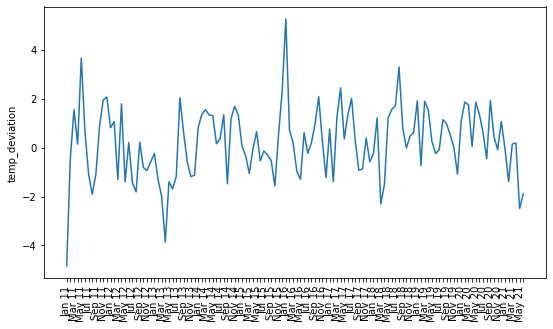

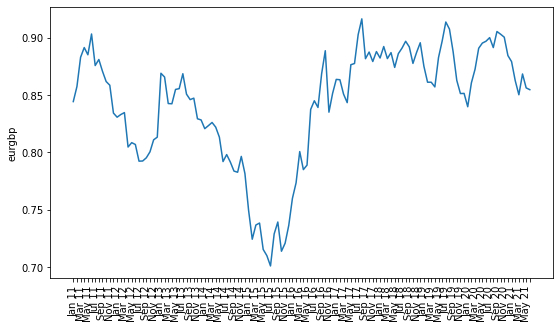

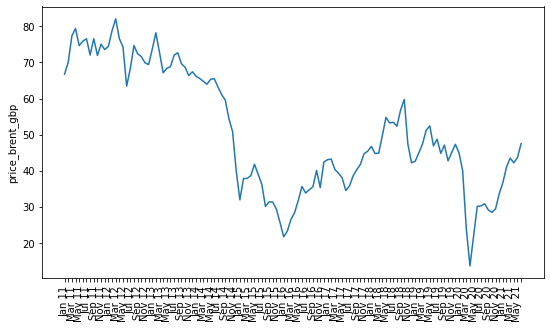

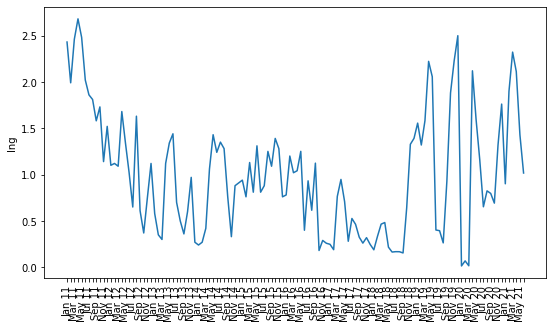

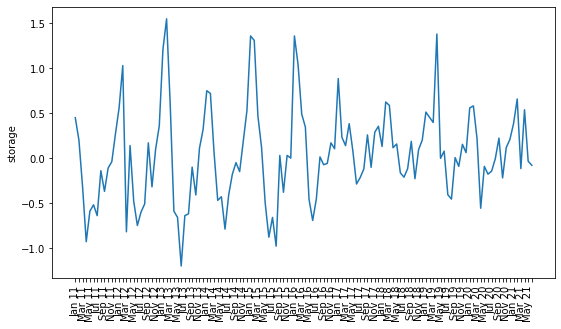

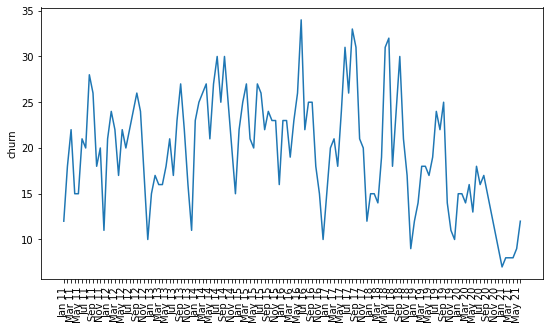

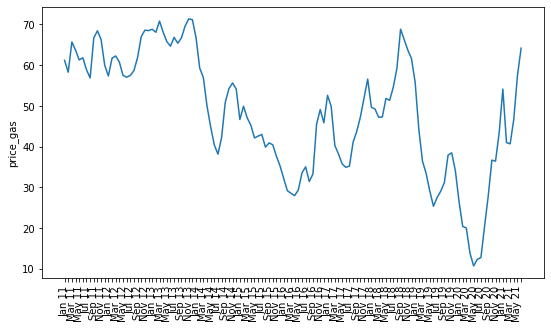

In [105]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### initiate corrected series
DataSeriesCorr=[]

#### select correction mode
TypeCorr = 'mixed' # 'HP' for filtering or 'log' or 'bothHPlog'

HP =['gbpusd', 'open_interest_gas','churn','eurgbp','gbpusd']
loga = ['price_brent_gbp','']

for df in DataSeries:

    if TypeCorr == "log" or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
            if df.name in loga:
                df_log = pd.Series(np.log(df))
                df = df_log


    if TypeCorr == 'HP' or TypeCorr == 'bothHPlog' or TypeCorr == 'mixed':
        if df.name in HP or TypeCorr == 'HP':
            cycle, trend = sm.tsa.filters.hpfilter(df, 129600)
            plt.plot(trend)
            plt.plot(cycle)
            cycle.name = df.name
            df = cycle

    if TypeCorr == 'diff':
        df_diff = df.diff().dropna()
        df = df_diff

    plt.figure(figsize=(9, 5))
    if TypeCorr == 'diff':        
        plt.plot(time.iloc[1:], df)
    else: 
        plt.plot(time, df)
    plt.ylabel(df.name)
    ax = plt.gca()
    plt.xticks(rotation=90)
    for label in ax.get_xaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
    plt.show()
    DataSeriesCorr.append(df)

df_corr = pd.concat(DataSeriesCorr,axis=1)



In [106]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
temp_deviation,-8.261315,0.000000,0.000000
eurgbp,-1.758229,0.401388,0.000000
price_brent_gbp,-1.852042,0.354947,2.000000
lng,-3.799564,0.002912,3.000000
storage,-2.882623,0.047406,11.000000
churn,0.502259,0.984942,12.000000
price_gas,-2.373811,0.149265,10.000000


In [107]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
temp_deviation,0.310280,0.100000,3.000000
eurgbp,0.547983,0.030860,6.000000
price_brent_gbp,1.174685,0.010000,6.000000
lng,0.348372,0.099409,5.000000
storage,0.224000,0.100000,5.000000
churn,0.631648,0.019759,5.000000
price_gas,0.944212,0.010000,6.000000


In [108]:
#### EXPORT NORMALISED DATA ####


df_export = df_corr

#df_export.insert(0,'months',time)
#print(df_export)
#df_export.to_excel(r'export_normal_data.xlsx', index = False)

#df_corr.drop(columns=['months'])
#print(df_corr)

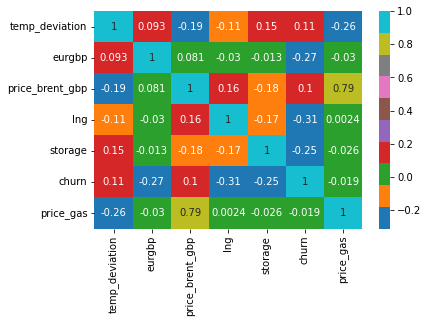

In [109]:
#### CORRELATION MATRIX ####

CorrelationMatrix=df_corr.corr()
ax=sns.heatmap(CorrelationMatrix, annot=True, cmap="tab10")


     temp_deviation   eurgbp  price_brent_gbp       lng   storage  churn  \
15        -4.838333  0.84430        66.785907  2.430000  0.450000     12   
16        -0.440000  0.85740        70.022260  1.990000  0.200000     18   
17         1.546667  0.88290        77.353399  2.460000 -0.320000     22   
18         0.138333  0.89142        79.431267  2.680000 -0.930000     15   
19         3.653333  0.88512        74.670881  2.480000 -0.590000     15   
..              ...      ...              ...       ...       ...    ...   
136       -1.390000  0.86262        40.980074  1.897236  0.658246      8   
137        0.146667  0.85026        43.494060  2.321223 -0.116558      8   
138        0.188333  0.86838        42.188306  2.111904  0.538452      8   
139       -2.496667  0.85624        43.616761  1.428956 -0.034491      9   
140       -1.893333  0.85469        47.484969  1.016736 -0.079826     12   

     price_gas  
15   61.175612  
16   58.253804  
17   65.671980  
18   63.693670  
19

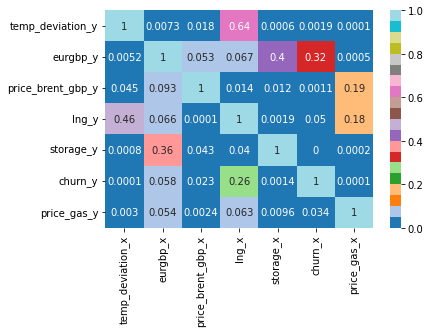

In [110]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    #plot
    sns.heatmap(df, annot=True, cmap="tab20")
    #return df


##### actual test
print(df_corr)
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


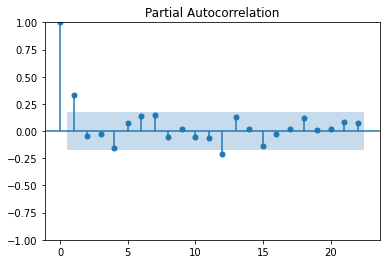

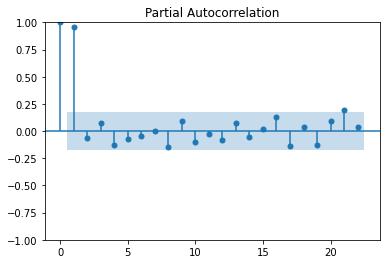

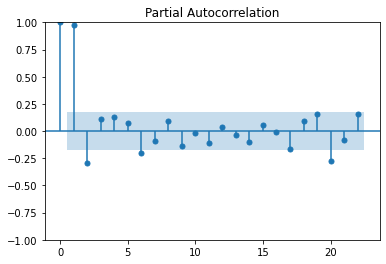

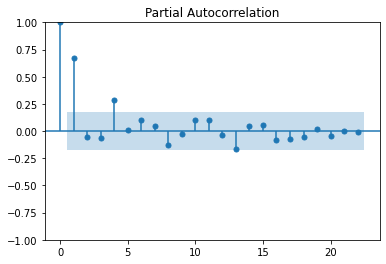

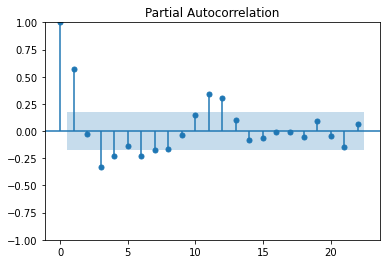

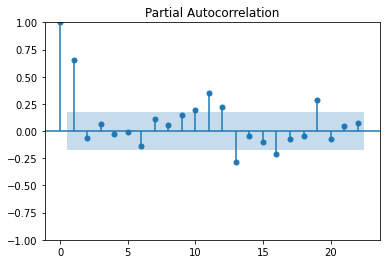

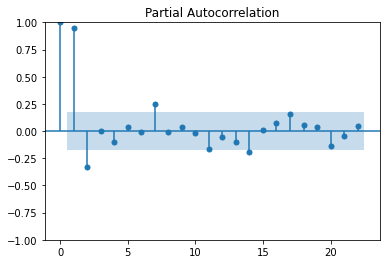

In [111]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()

# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()


In [112]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order()
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


,AIC,BIC,FPE,HQIC
0,5.238,5.407,188.3,5.307
1,-2.375,-1.024*,0.09314,-1.827*
2,-2.175,0.3598,0.1149,-1.146
3,-2.185,1.532,0.1165,-0.6770
4,-2.206,2.694,0.1196,-0.2178
5,-2.111,3.971,0.1422,0.3569
6,-2.123,5.142,0.1586,0.8249
7,-1.857,6.591,0.2473,1.571
8,-1.709,7.921,0.3687,2.199
9,-1.986,8.827,0.3966,2.402


In [113]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order =4
model_fit = model.fit(6)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Aug, 2022
Time:                     18:28:52
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    4.71976
Nobs:                     120.000    HQIC:                  0.567272
Log likelihood:          -754.577    FPE:                   0.130127
AIC:                     -2.27219    Det(Omega_mle):       0.0152518
--------------------------------------------------------------------
Results for equation temp_deviation
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -3.950923         3.525602           -1.121           0.262
L1.temp_deviation          0.391978         0.117739            3.329           0.001
L1.eurgbp                  9.81

True


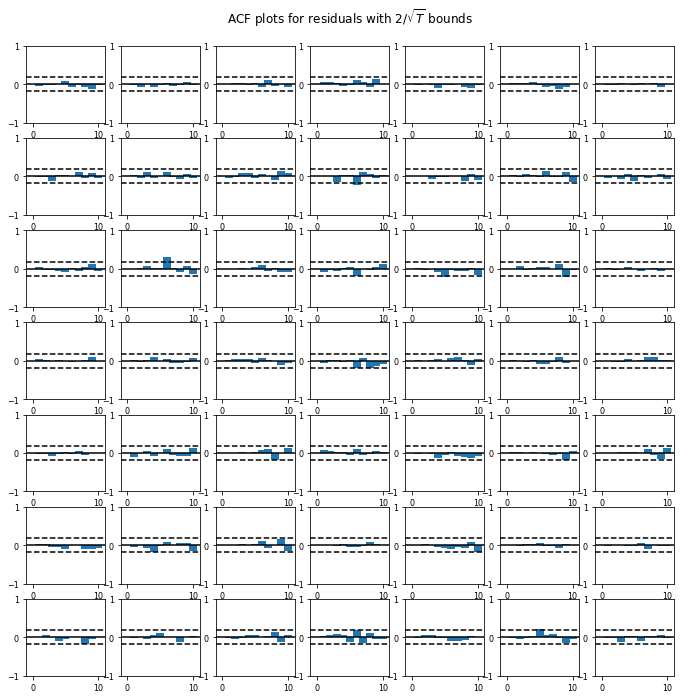

In [114]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
accor = model_fit.plot_acorr()

stab = model_fit.is_stable()
print(stab)

#if residuals out of range -> unstable model 

In [115]:
######### GRANGER CAUSALITY TEST #########
#for gas price
#GrangerCausality = model_fit.test_causality('price_gas', ['lng'], kind='f')
#print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

In [116]:
######### NORMALITY TEST #########

TestNorm = model_fit.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         19.67          23.68   0.141 14
----------------------------------------


In [117]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = model_fit.test_whiteness(nlags=18)
print(TestWhite.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 18 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         662.2          645.5   0.018 588
-----------------------------------------


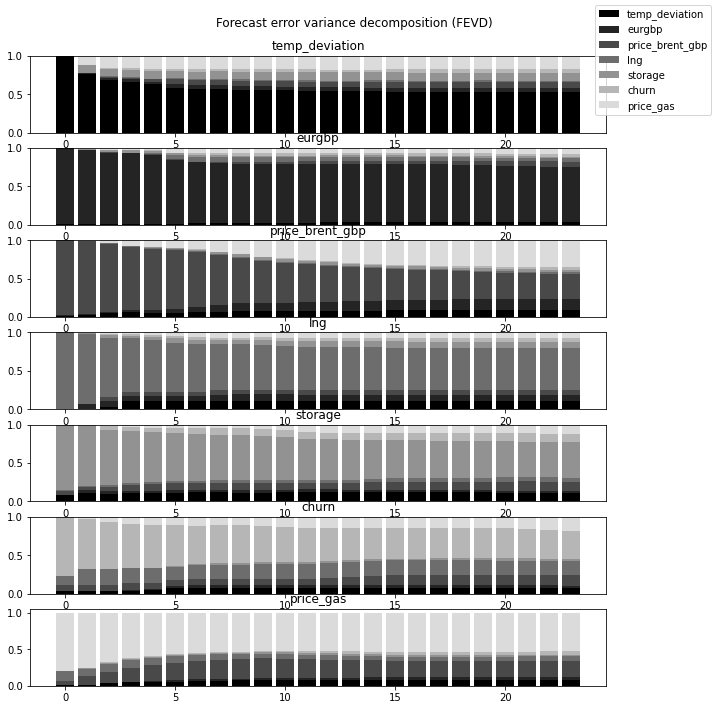

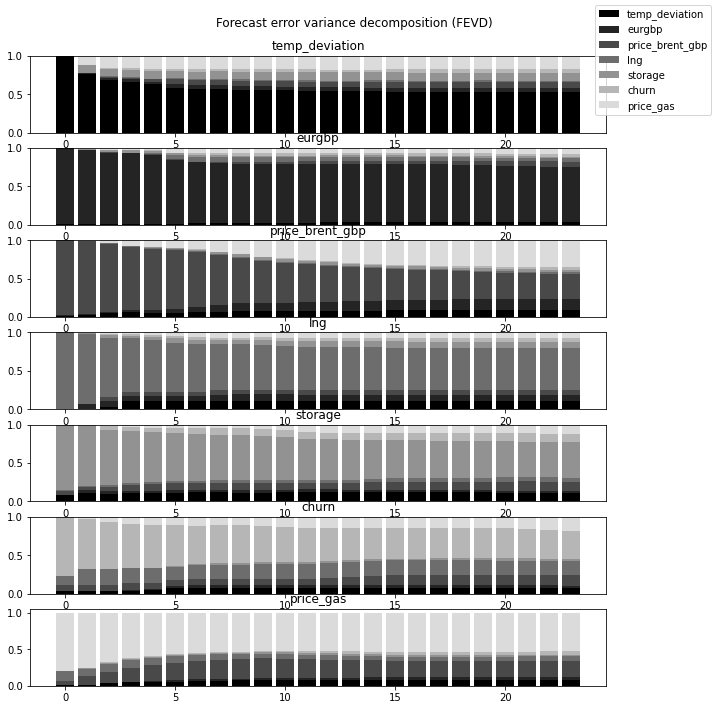

In [118]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=24
VD = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
VD.plot()

IMPULSE RESPONSE ANALYSIS:

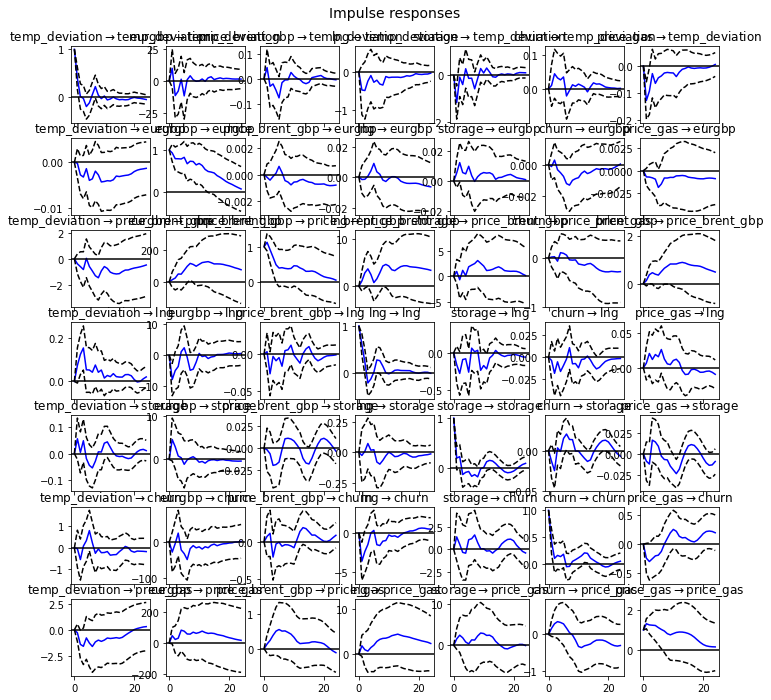

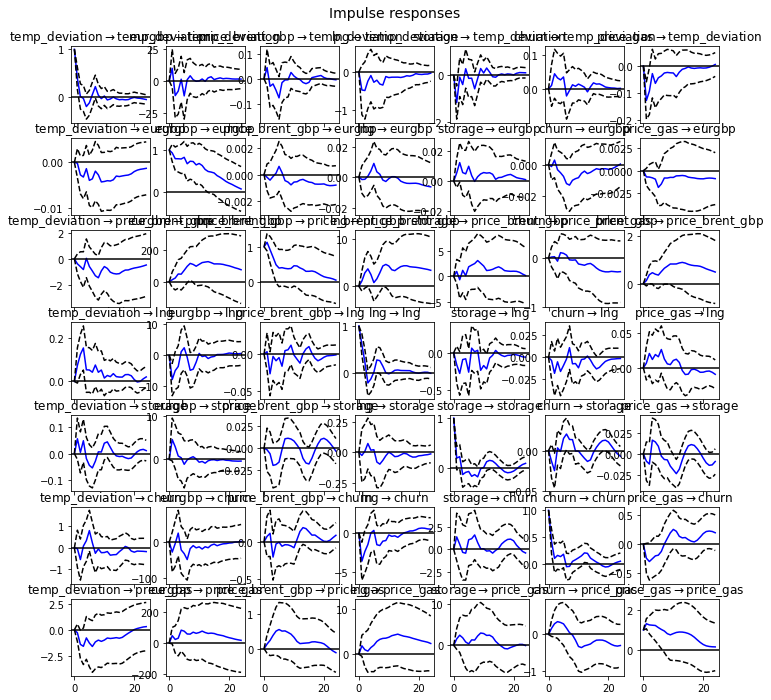

In [119]:
Impulse = model_fit.irf(24)

Impulse.plot()

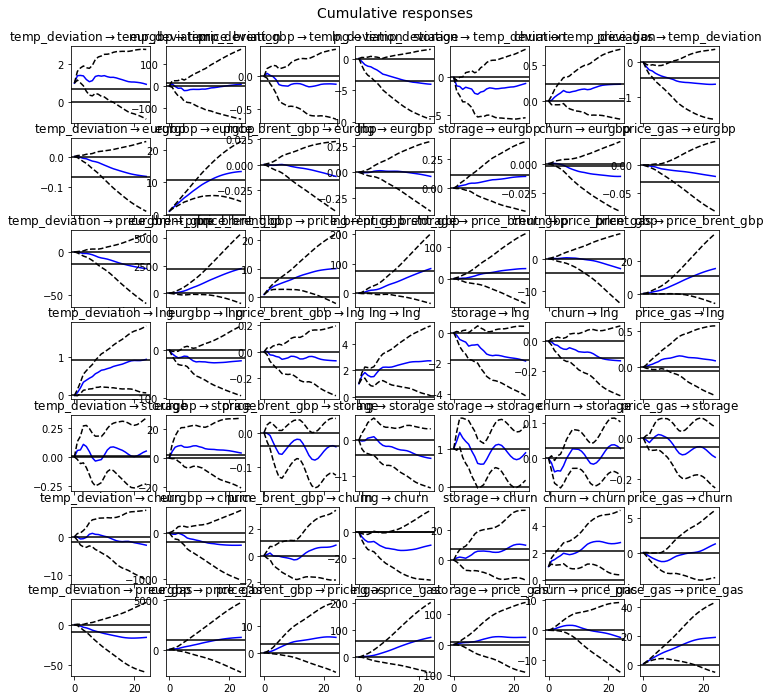

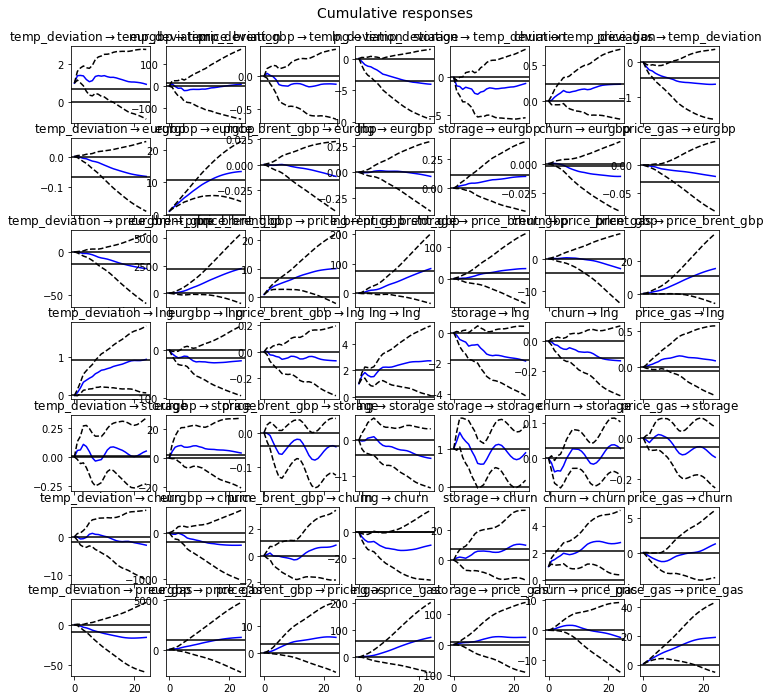

In [120]:
Impulse.plot_cum_effects(orth=False)

OTHER MODELS

In [133]:
from statsmodels.tsa.api import SVAR
 
lag_order = 2

#A = np.asarray([[0, 0, 0],['E', 0, 0],[0, 'E', 0]])
#B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])

#A = np.asarray([[1, 0, 0, 0, 0], ['E', 1, 0, 0, 'E'],['E', 0, 1, 0, 'E'],[0, 0, 'E', 1, 'E'],['E', 'E', 'E', 'E', 1]])
#A = np.asarray([['E', 0, 0, 0, 0], ['E', 'E', 'E', 'E', 'E'],['E', 'E', 'E', 0, 0],[0, 0, 0, 'E', 0],['E', 'E', 'E', 'E', 'E']])
#A = np.asarray([['E',0,0,0,0,0,0], [0,'E','E',0,0,0,0],[0,'E','E',0,0,0,0],['E',0,0,'E','E',0,'E'],['E',0,'E','E','E',0,'E'],['E','E','E','E','E','E','E'],['E','E','E','E','E',0,'E']])
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 'E'],[0, 0, 0, 0, 'E', 0, 'E'],['E', 'E', 'E', 'E', 'E', 'E', 'E'],['E', 'E', 'E', 'E', 'E', 0, 'E']])
#A = np.asarray([['E', 0, 0, 0, 0, 0, 0], [0, 'E', 0, 0, 0, 0, 0],[0, 0, 'E', 0, 0, 0, 0],[0, 0, 0, 'E', 0, 0, 0],[0, 0, 0, 0, 'E', 0, 0],[0, 0, 0, 0, 0, 'E', 0],[0, 0, 'E', 0, 0, 0, 'E']])
A = np.asarray([['E', 0, 0, 0, 0, 0, 0], ['E', 'E', 0, 0, 0, 0, 0],['E', 'E', 'E', 0, 0, 0, 0],['E', 'E', 'E', 'E', 0, 0, 0],['E', 'E', 'E', 'E', 'E', 0, 0],['E', 'E', 'E', 'E', 'E', 'E', 0],['E', 'E', 'E', 'E', 'E', 'E', 'E']])


StructModel = SVAR(df_corr,svar_type='A', A=A)

#dtempdev, dstore, dlng, dprice_brent_gbp, drange

ResSVAR = StructModel.fit(maxlags=lag_order, maxiter=10000, maxfun=10000, solver='bfgs')



/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
##### IS STABLE ? #####
Stab = ResSVAR.is_stable()
print("SVAR model is stable ? :   ",Stab)

SVAR model is stable ? :    True


In [135]:
######### Whiteness TEST ######### (absence of significant residual autocorrelations)

TestWhite = ResSVAR.test_whiteness(nlags=24)
print(TestWhite.summary())

#Portmanteau test

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 24 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df 
------------------------------------------
         1130.          1155.   0.131 1078
------------------------------------------


In [136]:
######### NORMALITY TEST #########

TestNorm = ResSVAR.test_normality()
print(TestNorm.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         67.79          23.68   0.000 14
----------------------------------------


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lucruffie/Library/Pyt

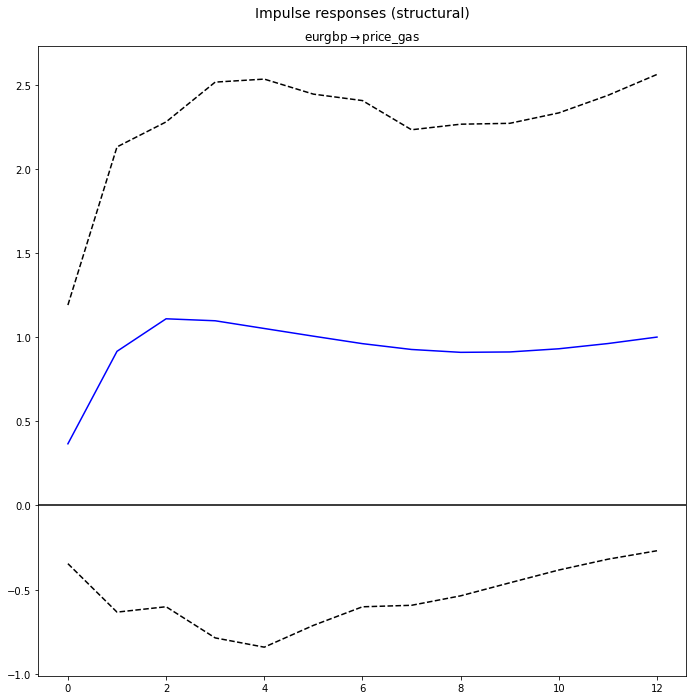

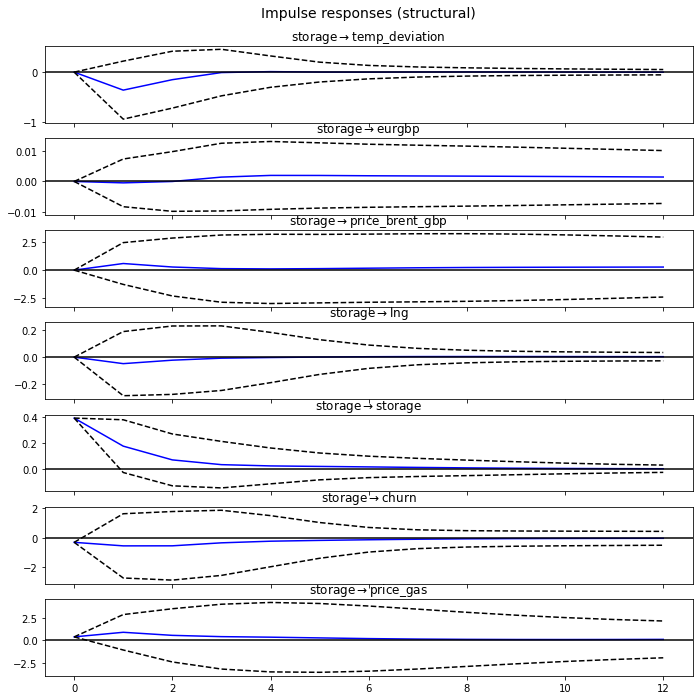

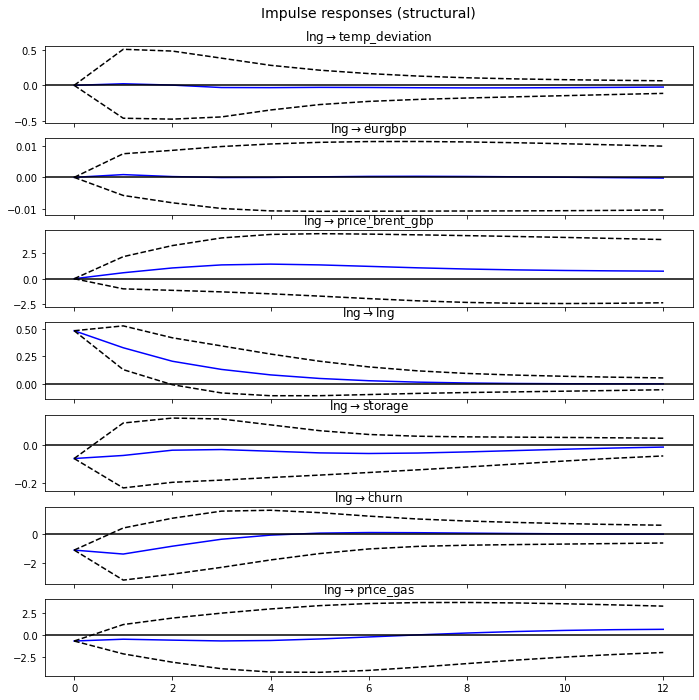

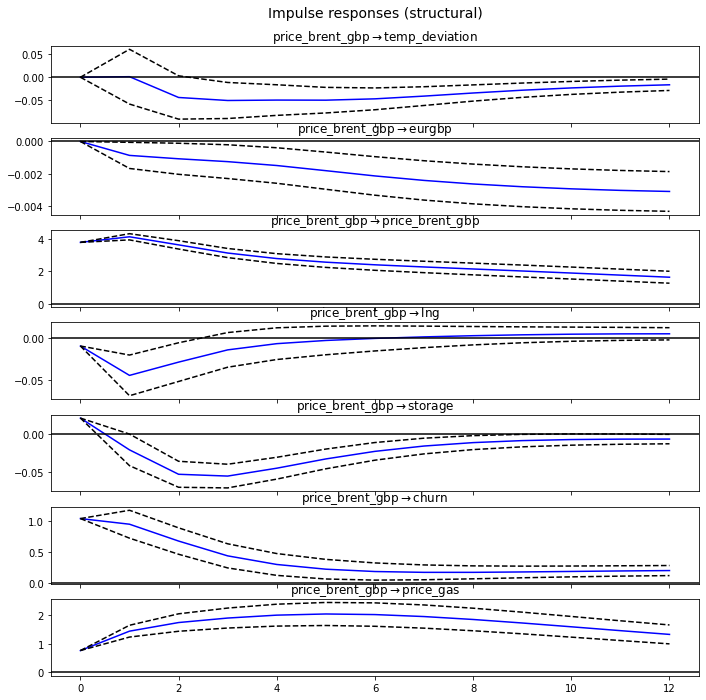

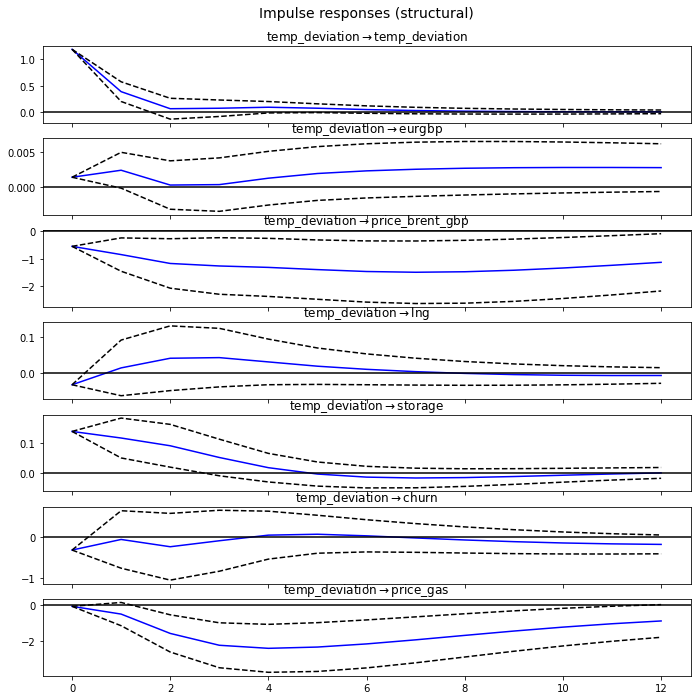

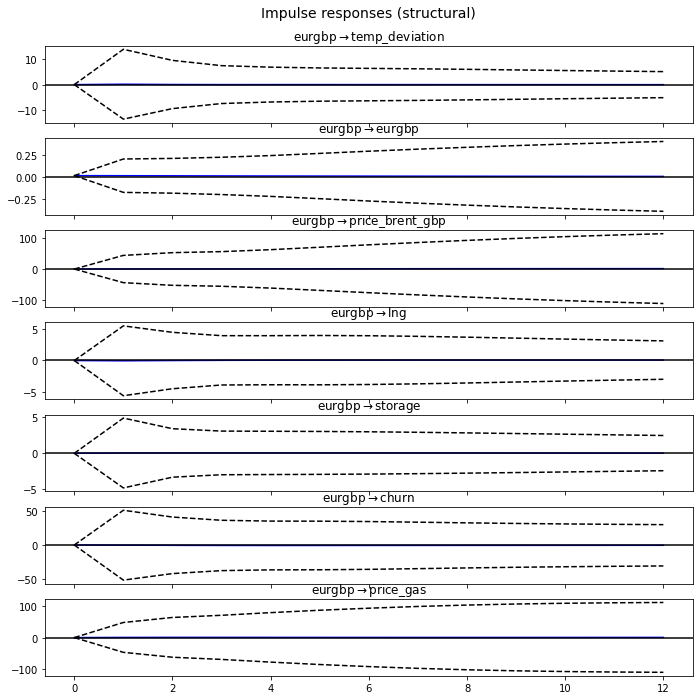

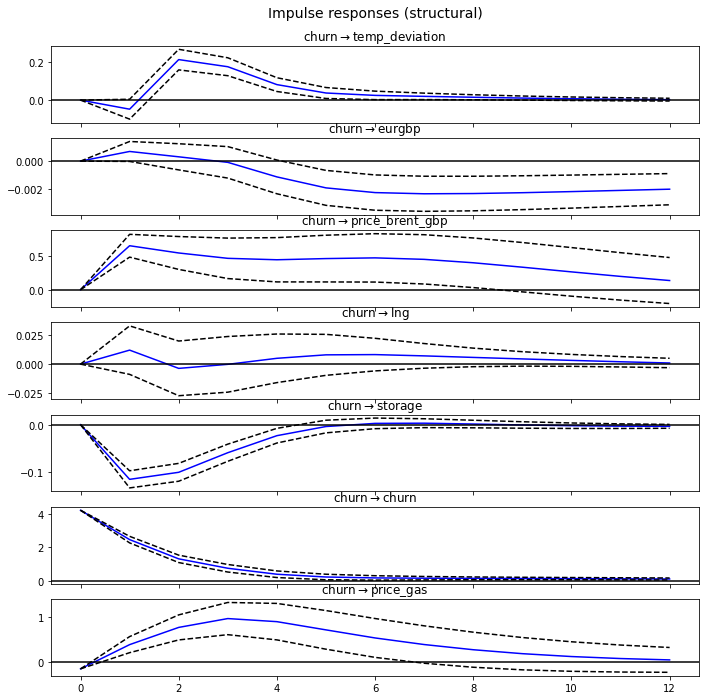

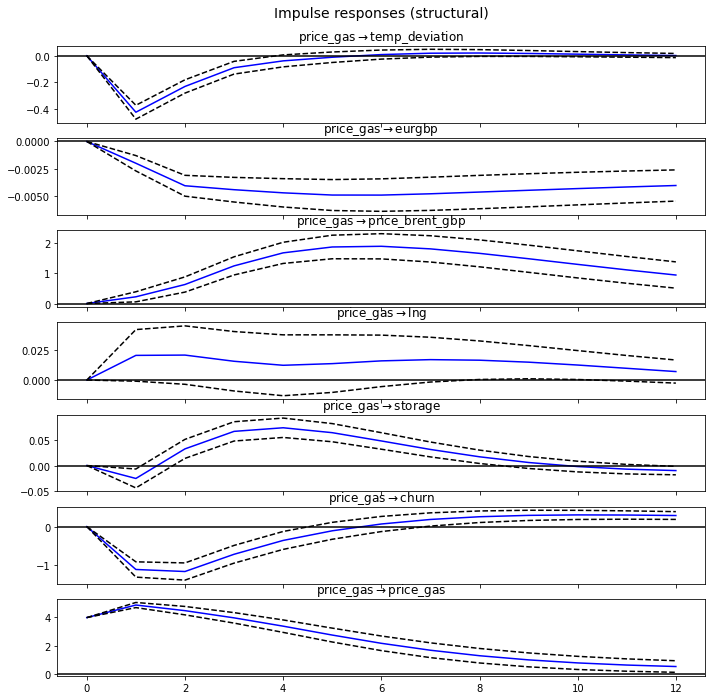

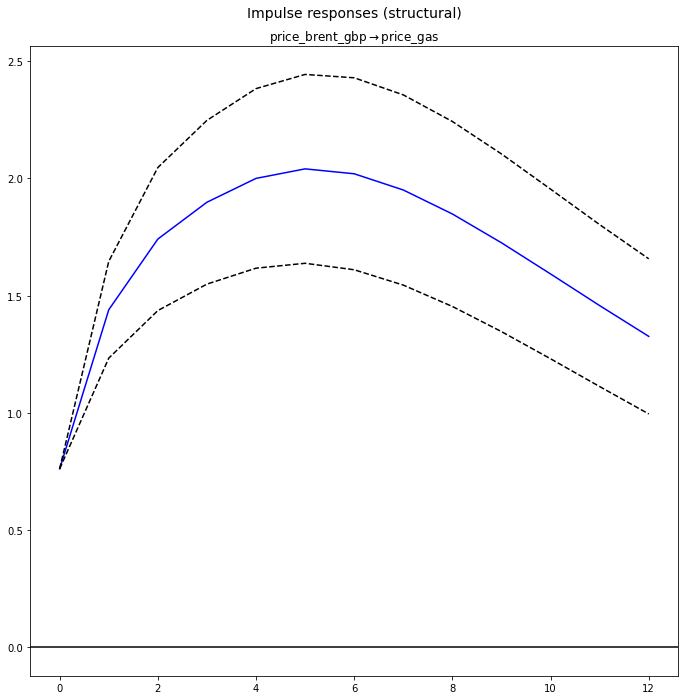

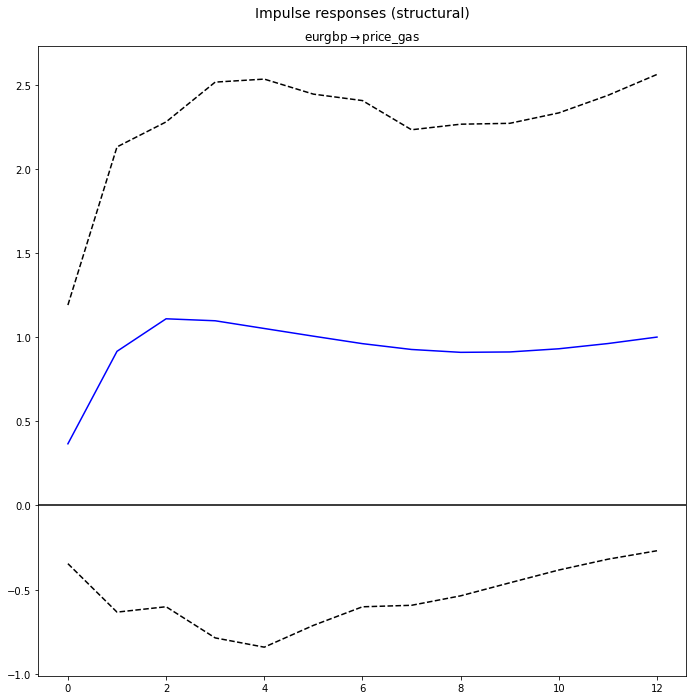

In [144]:
#### IR ####


ResSVAR.irf(periods=12).plot(impulse='storage', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='lng', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='price_brent_gbp', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='temp_deviation', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='eurgbp', plot_stderr=True,stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='churn', plot_stderr=True,stderr_type='asym', repl=100)

ResSVAR.irf(periods=12).plot(impulse='price_gas', plot_stderr=True,stderr_type='asym', repl=100)


ResSVAR.irf(periods=12).plot(impulse='price_brent_gbp', response="price_gas" ,plot_stderr=True, stderr_type='asym', repl=100)
ResSVAR.irf(periods=12).plot(impulse='eurgbp', response="price_gas" ,plot_stderr=True, stderr_type='mc', repl=100)




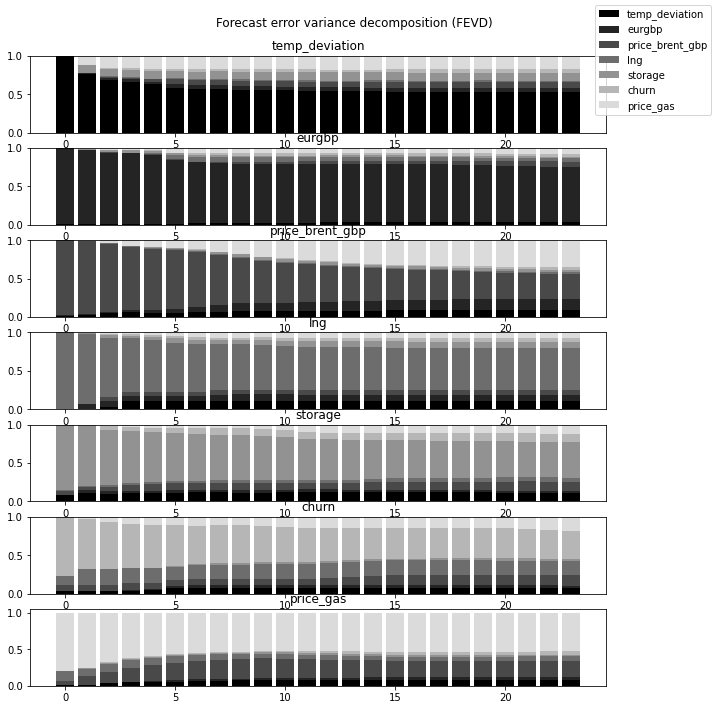

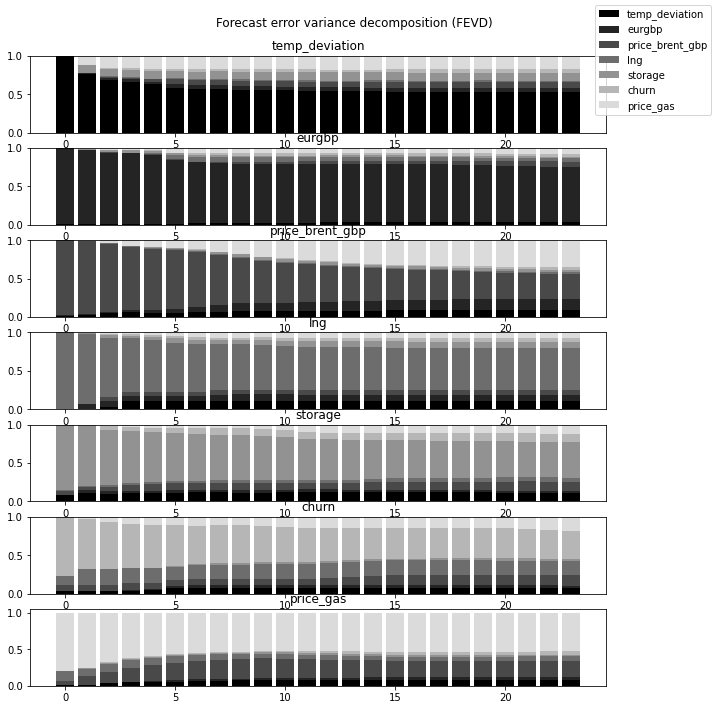

In [145]:
#### FEVD ####


#only for 20 periods
n=24
fevd = model_fit.fevd(n)
#fevd.summary()

#affichage pour n périodes
model_fit.fevd(n).plot()

[[ 1.06833333e+00  8.84420000e-01  3.35848655e+01  1.76047760e+00
   2.08526700e-01  9.00000000e+00  4.34209838e+01]
 [-3.83333333e-02  8.79180000e-01  3.66610753e+01  9.00602300e-01
   3.84170900e-01  7.00000000e+00  5.41055046e+01]
 [-1.39000000e+00  8.62620000e-01  4.09800739e+01  1.89723610e+00
   6.58245900e-01  8.00000000e+00  4.09679193e+01]
 [ 1.46666667e-01  8.50260000e-01  4.34940603e+01  2.32122290e+00
  -1.16557500e-01  8.00000000e+00  4.06589302e+01]
 [ 1.88333333e-01  8.68380000e-01  4.21883061e+01  2.11190430e+00
   5.38452400e-01  8.00000000e+00  4.67125341e+01]
 [-2.49666667e+00  8.56240000e-01  4.36167607e+01  1.42895570e+00
  -3.44906000e-02  9.00000000e+00  5.74111723e+01]
 [-1.89333333e+00  8.54690000e-01  4.74849688e+01  1.01673580e+00
  -7.98262000e-02  1.20000000e+01  6.41472678e+01]]
49
[[ 1.26478648e+00  8.06497964e-01  6.81776690e+01  9.29675595e-01
  -7.95021117e-01 -1.13589194e+01  7.32789945e+01]
 [ 3.31764303e+00  7.52670456e-01  8.29267904e+01  1.0410281

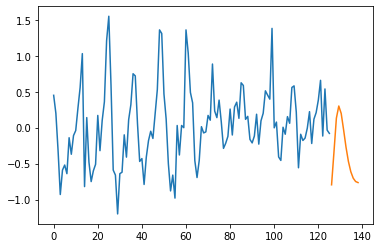

In [146]:
#### Forecast ####

#from fractions import Fraction


from numpy import linspace


yarray=df_corr.to_numpy()
#print(y)
y=yarray[119:,:]
print(y)
print(y.size)
ResSVAR.exog = None
ResSVAR.coefs_exog = np.array(0)
ResSVAR.trend = "n"

steps = 12
ForecastSVAR = ResSVAR.forecast(y,steps)

print(ForecastSVAR)
ForecastPriceGas = ForecastSVAR[:,4]

serie=yarray[:,4]
print(serie.size)
length=serie.size
xserie = np.linspace(0,length-1,length)
xforecast = np.linspace(length,length+steps,steps)

print(xserie.size)
print(xforecast.size)


print()
plt.plot(xserie,serie)
plt.plot(xforecast,ForecastPriceGas)
plt.show()


138
[61.1756115  61.6256115  61.8256115  61.5056115  60.5756115  59.9856115
 59.4656115  58.8256115  58.6856115  58.3156115  58.2056115  58.1656115
 58.4356115  58.9956115  60.0256115  59.2056115  59.3456115  58.8656115
 58.1156115  57.5156115  57.0056115  57.1756115  56.8556115  56.9556115
 57.3156115  58.5256115  60.0756115  60.6656115  60.0756115  59.4156115
 58.2156115  57.5756115  56.9556115  56.8556115  56.4456115  56.5556115
 56.8756115  57.6256115  58.3456115  58.4056115  57.9356115  57.5056115
 56.7156115  56.3056115  56.1256115  56.0756115  55.9256115  56.1156115
 56.6456115  58.0056115  59.3156115  59.7856115  59.9056115  59.4056115
 58.5256115  57.8656115  56.8856115  56.9156115  56.5356115  56.5656115
 56.5656115  57.9256115  58.9656115  59.4556115  59.8008858  59.3426197
 58.6487478  58.19398885 58.20747905 58.13436938 58.07552868 58.24553818
 58.34957138 59.23471098 59.46664388 59.60623238 59.98965568 60.06886128
 59.78082128 59.56399288 59.44299258 59.70162358 59.599547

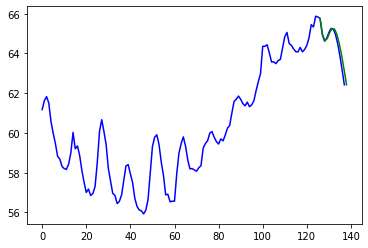

In [147]:
#### DIFF INV ####
diff_total = np.concatenate((yarray[:,4], ForecastPriceGas), axis=0)
#print(yarray[:,4])
#print(set_total)

length_set = yarray[:,4].size + steps
print(length_set)
PriceReal = np.linspace(0,length_set,length_set)
PriceReal[0] = dprice_gas.values[0]

for i in range(1,length_set):
    PriceReal[i] = diff_total[i-1] + PriceReal[i-1]

print(PriceReal)
forecasted = PriceReal[-steps:]
print(forecasted)
print(PriceReal.size)

plt.plot(PriceReal, color='blue')
plt.plot(xforecast,forecasted,color="green")
plt.show()


(array([[ 1.26478648e+00,  8.06497964e-01,  6.81776690e+01,
         9.29675595e-01, -7.95021117e-01, -1.13589194e+01,
         7.32789945e+01],
       [ 3.31764303e+00,  7.52670456e-01,  8.29267904e+01,
         1.04102815e+00, -3.38415197e-01, -2.14902349e+01,
         7.69818834e+01],
       [ 2.13374993e+00,  6.95444798e-01,  9.55897909e+01,
         1.24363988e+00,  1.31680936e-01, -2.49633941e+01,
         7.64062488e+01],
       [ 8.56433670e-01,  6.38679932e-01,  1.05939263e+02,
         1.37827110e+00,  3.01200201e-01, -2.53736119e+01,
         7.31747549e+01],
       [ 2.25298090e-01,  5.90960730e-01,  1.13879451e+02,
         1.42352301e+00,  1.98677865e-01, -2.37670690e+01,
         7.00465015e+01],
       [-1.18457083e-01,  5.51042258e-01,  1.19436506e+02,
         1.39870664e+00, -2.94806542e-02, -2.14893847e+01,
         6.83163851e+01],
       [-4.15206624e-01,  5.15248832e-01,  1.22981767e+02,
         1.33764889e+00, -2.70339784e-01, -1.93235753e+01,
         6.802479

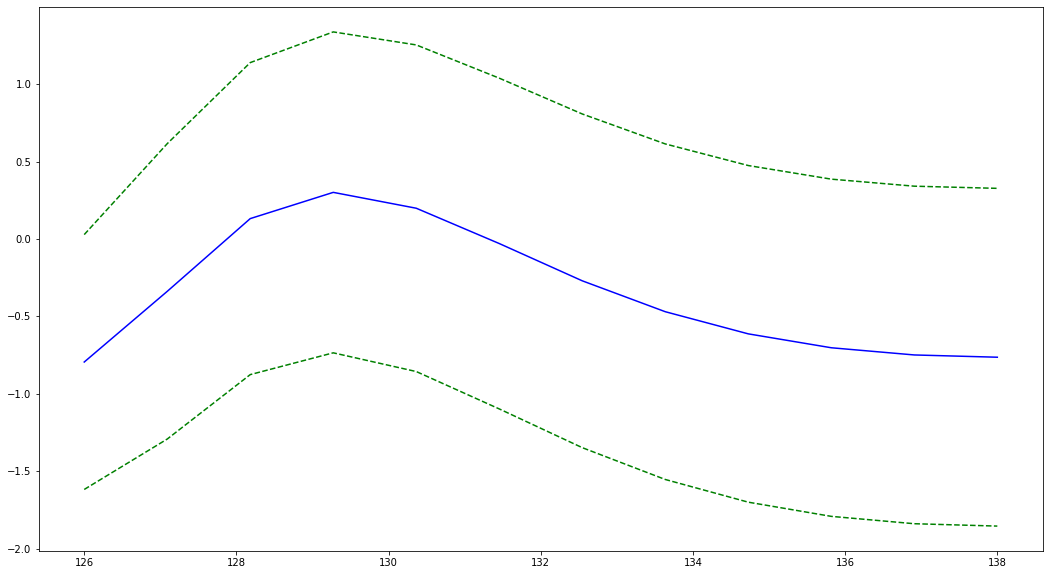

[64.14726783 62.85459168 61.97831019 61.24273503 60.386226   59.2881618
 57.93977991 56.38576576 54.68515384 52.89286572 51.05306656 49.19796521]


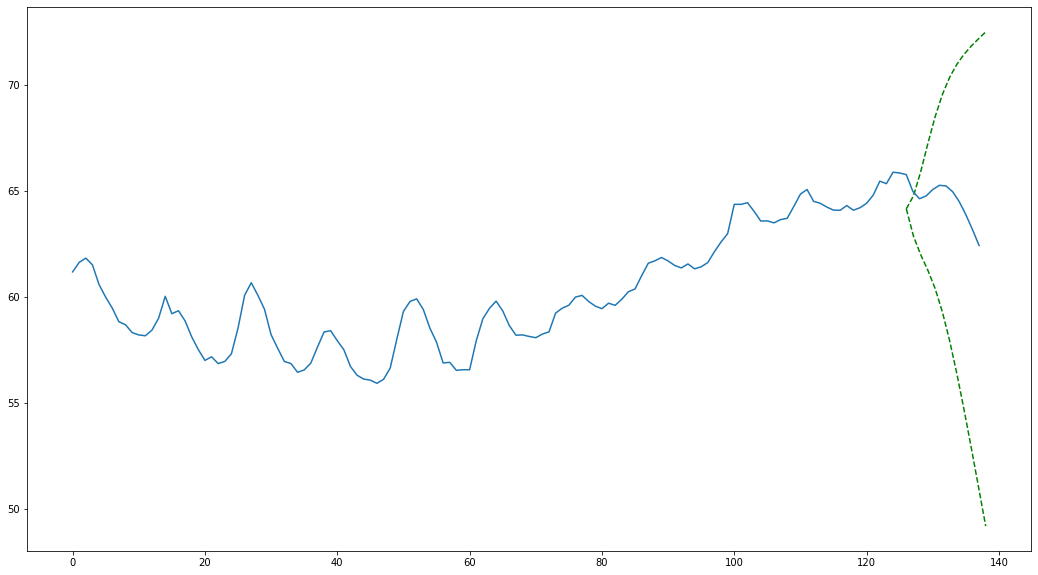

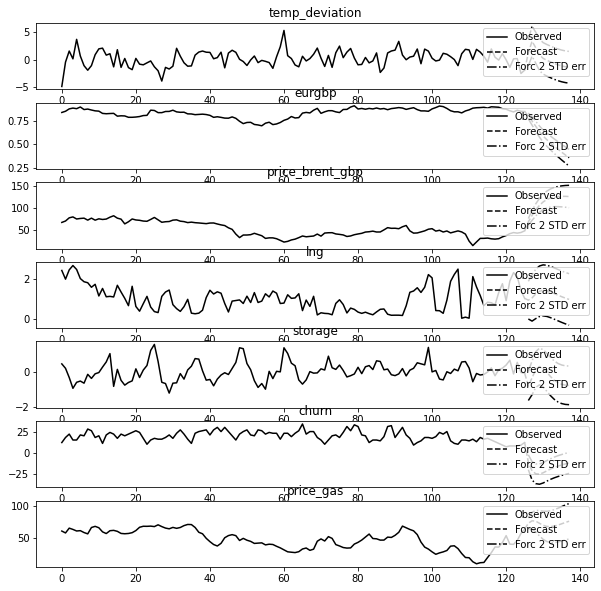

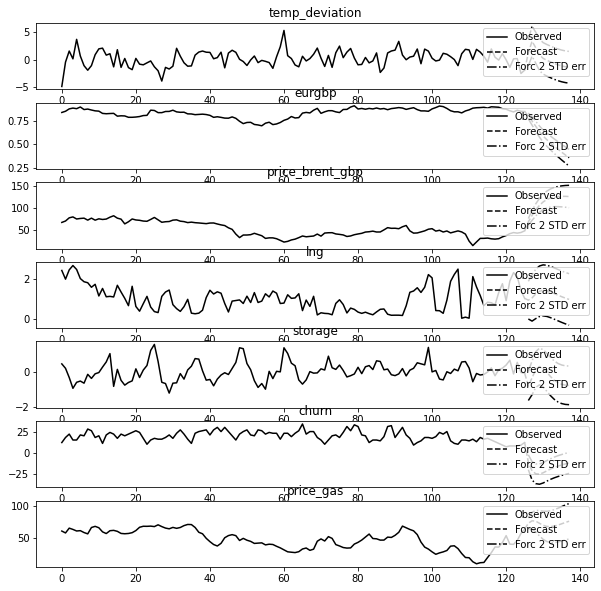

In [148]:
ForecastIntSVAR = ResSVAR.forecast_interval(y,steps)
print(ForecastIntSVAR)

# differenciated
UpBandDiff = ForecastIntSVAR[2][:,4]
LowBandDiff = ForecastIntSVAR[1][:,4]
MidDiff = ForecastIntSVAR[0][:,4]

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBandDiff, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBandDiff, color="green",linestyle='dashed')
plt.plot(xforecast,MidDiff,color="blue")
plt.show()


# integrated
last_val = dprice_gas.values[-1]

UpBand = UpBandDiff
LowBand = LowBandDiff 

UpBand[0] = last_val
LowBand[0] = last_val

for i in range(1,steps):
    UpBand[i] = UpBand[i-1] + UpBandDiff[i]
    LowBand[i] = LowBand[i-1] + LowBandDiff[i]

print(LowBand)
xforecast = np.linspace(length,length+steps,steps)

plt.figure(figsize=(18, 10))
plt.plot(xforecast,UpBand, color ="green",linestyle='dashed')
plt.plot(xforecast,LowBand, color ="green",linestyle='dashed')
plt.plot(PriceReal)
plt.show()

ResSVAR.plot_forecast(steps)

#ResSVAR.plotsim()

In [149]:
long_run = ResSVAR.test_inst_causality("lng")
long_run.summary()

Test statistic,Critical value,p-value,df
15.02,12.59,0.020,6


(array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+0

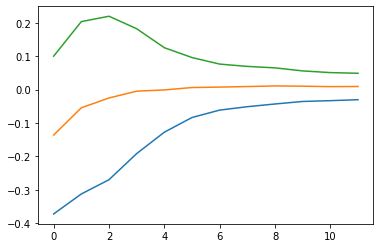

12
12
[64.14726783 63.21626827 62.82353211 62.93028054 63.22694589 63.42477932
 63.40167753 63.13901117 62.67837773 62.07652168 61.38406619 60.64377809]
64.14726783468105
[-0.9309995678995655, -0.39273615242066573, 0.10674842384319602, 0.2966653558573069, 0.19783342465514486, -0.02310178646159082, -0.26266636543453364, -0.4606334371186766, -0.6018560479777996, -0.6924554950812732, -0.7402880939398484, -0.7544838866144976]
12


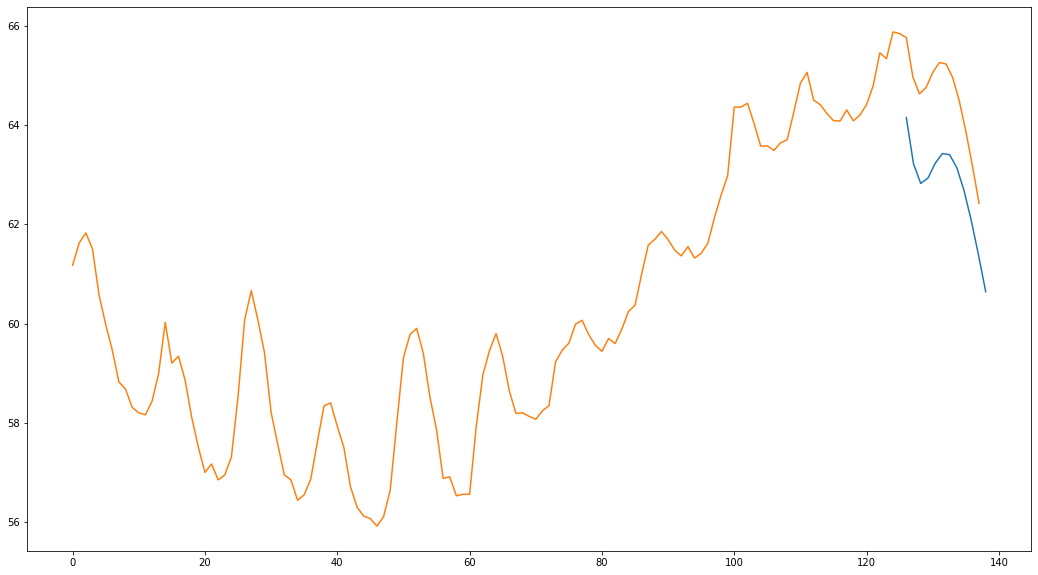

In [150]:
#### SCENARIOS FORECAST ####

ResimBand = ResSVAR.irf_errband_mc(steps=steps,cum=False) #Tuple of lower and upper arrays of ma_rep monte carlo standard errors
Resim = ResSVAR.irf_resim()
print(ResimBand)

print(ResimBand[0])
UpperBand = []
LowerBand = []
Mid = []

for i in range(1,steps+1):
    UpperBand.append(ResimBand[0][i][3][4])
    LowerBand.append(ResimBand[1][i][3][4])



print("---------------------------")
print(UpperBand)

print("---------------------------")
print(LowerBand)


for i in range(0, steps):
    Mid.append((UpperBand[i] + LowerBand[i])/2)


plt.plot(UpperBand)
plt.plot(Mid)
plt.plot(LowerBand)
plt.show()

###########################

MidDiffTot = []
diff_forecast = diff_total[-steps:]
print(len(diff_forecast))
print(len(Mid))
for i in range(0,len(Mid)):
    MidDiffTot.append(Mid[i] + diff_forecast[i])

MidImp = np.linspace(0,steps,steps)
MidImp[0] = last_val

for i in range(1,steps):
    MidImp[i] = MidImp[i-1] + MidDiffTot[i-1]

print(MidImp)
print(last_val)
print(MidDiffTot)
print(len(MidImp))
plt.figure(figsize=(18, 10))
plt.plot(xforecast,MidImp)
plt.plot(PriceReal)
plt.show()